In [7]:
using LinearAlgebra
using SymPy

┌ Info: Precompiling SymPy [24249f21-da20-56a4-8eb1-6a02cf4ae2e6]
└ @ Base loading.jl:1260


Let's do some fun stuff. Let's try to code up some PDES. monte carlo style?

This seems like a good example. It would be somewhat difficult to code this up efficiently in python

Maybe I should be doing ray tracing and stuff in julia.

I can go onto GPU, which it seems like julia should be strong for.


SIGGRAPH papers

http://www.cs.cmu.edu/~kmcrane/Projects/MonteCarloGeometryProcessing/index.html


https://en.wikipedia.org/wiki/Walk-on-spheres_method
http://graphics.ucsd.edu/~henrik/papers/book/
Rendering equation of kajiya https://youtu.be/bFn-wjQtxZ0?t=2410


It's interesting. One might say that the primary physical intutition for neumann series and theb orn approximation and stuff comes from the bouncing of light rays. This might be the primary location
The pinball diagrams of Mattuck. He is talking about probablitlty, but you could be talking about the rendering equation just as well. 
Utah pproximation = first born approximation
You could do feynman diagrams if you had some non trivial light light interaction





1-d monte carlo solver for
$\partial^2 \phi = f(x)$


The solution of teh 1-d Laplace equation is absolutely trivial. If the second derivative is 0, then $\phi = a + b x $. This line is found by fitting it to the two endpoint values.


In the presence of discrete forcing terms f, it is striagthforward as well. It is a piecewise linear thing with derivative jumps occuring at every f position. It looks like a taught rubbr band with weights hanging from those points.


In [25]:
typeof(x -> x + 3)

var"#3#4"

In [5]:
rand(Float64, 3)

3-element Array{Float64,1}:
 0.7659881356450857
 0.7554491521825928
 0.10722161039470435

In [16]:
@vars x y 
@vars k positive=true real=true
ϕ = SymFunction("phi")

phi

In [19]:
Eq(diff(ϕ(x),x,x),0)

  2          
 d           
───(φ(x)) = 0
  2          
dx           

In [201]:
@vars a x ϕ

avg = ( ϕ(x+a) + ϕ(x-a) ) / 2

# when a is zero, the average = phi(x) of course
@assert(   iszero(  avg.subs(a,0) - ϕ(x)   )  )

# this is the derivative of the average 
# does this equal zero?
change_of_avg = diff(avg,a) 

@assert(   iszero(  ϕ(x) + integrate(change_of_avg, (a,0,a))  - avg  )  )

# these two expressions are the same
@assert(  iszero(diff(avg,a) - integrate(diff(ϕ(y), y,y), (y, x-a, x+a))))

# when we use the laplace equation we do indeed see this expression is zero
SymPy.integrate(diff(ϕ(y), y,y), (y, x-a, x+a)).subs(diff(ϕ(y), y,y), 0)


0

The higher dimensional analog is that an integral over a a ball changes by $ \int dA \nabla \phi \cdot \hat{n} $ which by gauss's theorem correspond to the integral of the laplacian $ \int dV \nabla^2 \phi $ throughout the region, which is zero by assumption.




The expectation of the two endpoints is of course $E_x[\phi(x)] = p_a\phi(a) + p_{-a}\phi(-a)$ which if we give equal probability is the same as the avergae of the two endpoints


if x > 0 then  50%  x -> a , 50% x -> x - (a-x) = 2 * x - a
if x < 0 then 50% x -> -a  ,   50% x -> x + (x +a) = 2 * x + a


starting at x
E(x) = x >0 then  0.5 * phi(a) + 0.5 * E(2*x - a)
     = x < 0 then ...
     
Lordy, that's a weird functionsl equation. It will be solved by E[x] = cx + d which gives ? 

cx + d = 0.5 phi(a) + 0.5 * (c(2x - a)  d) 
cx + d = 0.5 phi(-a) + 0.5 * (c(2x + a) + d)

the x term is fine

d = 0.5 phia + 0.5 * (d - c a)
d = 0.5 phi-a + 0.5 (c a + d)

d = phia + phi-a  / 2
and c = phi - phi / a 
Very good.



Ok. So we connect this back to the laplace equation via the ball property.




 

     

In [204]:
avg = 0
phi0 = 0
phi1 = 10
x_0 = 0.75
function monte_run(x)
    while true
            l = rand(Bool) # go left?
            if (l && x <= 0.5) # finish at left edge 0
                return phi0
            elseif (!l && x >= 0.5) # finish at right edge 1
                return phi1
            else
                if x <= 0.5 # move away from 0
                    x += x
                else
                    x -= 1 - x # move away from 1
                end
            end
    end
end

monte_runs = [monte_run(x) for run_num =1:100, x=0:0.05:1 ]



100×21 Array{Int64,2}:
 0   0   0   0   0   0  10  10   0  10  …  10   0   0  10  10  10   0  10  10
 0   0   0   0  10   0  10   0  10  10     10   0  10  10  10  10  10  10  10
 0   0   0   0   0   0  10  10   0  10      0  10  10  10   0  10  10  10  10
 0   0   0   0  10   0   0   0   0   0      0  10   0  10  10  10  10  10  10
 0   0   0   0   0  10  10   0   0  10     10   0  10  10  10   0  10  10  10
 0   0   0   0   0   0   0   0   0   0  …   0  10   0  10  10  10  10  10  10
 0   0  10   0   0  10   0  10   0   0     10   0  10  10  10  10  10  10  10
 0   0   0   0   0   0  10  10   0   0     10  10  10   0  10  10  10  10  10
 0   0   0   0   0   0   0   0  10  10      0  10   0   0  10  10  10  10  10
 0   0   0   0   0   0   0   0  10   0     10  10  10  10   0  10  10  10  10
 0   0   0   0   0   0   0   0   0  10  …  10   0  10  10  10  10  10  10  10
 0   0   0   0   0   0   0  10   0  10     10   0  10   0  10  10  10  10  10
 0  10   0  10  10   0   0   0   0  10   

In [180]:
import Statistics
avgs = vec(Statistics.mean( monte_runs , dims=1))
stddevs = vec(Statistics.std(monte_runs, dims=1)) ./ sqrt(size(monte_runs)[1]) # something like this right?

21-element Array{Float64,1}:
 0.0
 0.23868325657594203
 0.31446603773522014
 0.3588702812826367
 0.41633319989322654
 0.46056618647183833
 0.41633319989322654
 0.47609522856952335
 0.4512608598542129
 0.5021167315686783
 0.49236596391733095
 0.5
 0.4688261722621506
 0.48783173121456336
 0.4351941398892446
 0.44619604333847374
 0.42295258468165065
 0.37752516806863695
 0.2564323999762428
 0.1969463855669324
 0.0

In [104]:
using Plots

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260


In [114]:
using LinearAlgebra
[x for x in 0:0.1:1]

11-element Array{Float64,1}:
 0.0
 0.1
 0.2
 0.3
 0.4
 0.5
 0.6
 0.7
 0.8
 0.9
 1.0

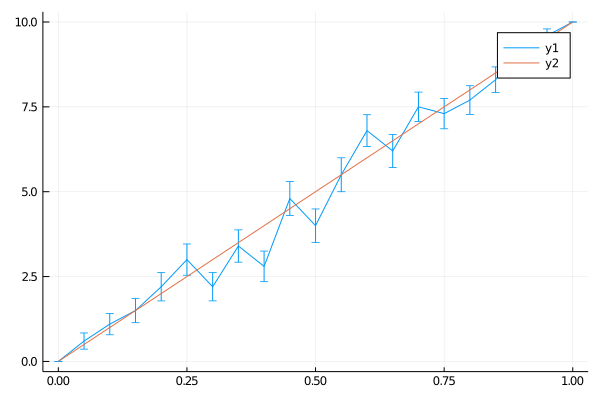

In [185]:
plot(0:0.05:1, avgs, yerror=stddevs)
plot!(0:0.05:1,  (0:0.05:1) * 10 )

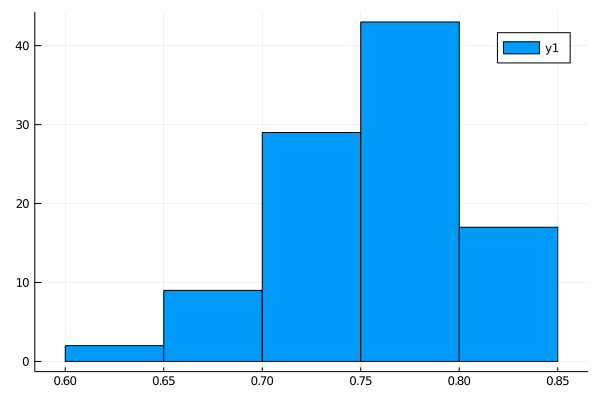

In [106]:
histogram(monte_runs)

I found the the discretized finite step form of the laplacian added clarity to the monte carlo algorithm. We can describe both probablistic dynamics and the second derivative as matrices. Probablistic dynamics can also be estimated by running them. By scaling and interpeting the derivative matrix as probabilities, we can run a monte carlo process that estimates a pde. Pretty neat.





A mostly unrelated idea.

What about PDEs defined on distance function or polynomial domains
This monte carlo thing gives one method


But on a polynomial ddomain, we can form functions that ibey the homegenous boundary conditions by working in the ideal of that polynomial
There is also the quotient spapce, which might be what we do for boundary value problems?

Integrating the volume / orthogonalizing these fucntions with respects to L2 seems difficukt. We could L2 with respect to a larger box. We could monte carlo the L2, but why go all algerbaic anyway then



However we could use SOS to minimize the L\inf norm
Or we could use weakened SOS , DSOS, SDSOS or sum of positives

Isn't that fun?




Can we find the volume is a semi-algebraic region? I feel skeptical. x^2 + y^2 <= 1  has area pi. How the hell are you goin to get pi

To what degree is taking a derivative an algebraic opration?

f(x+dx) mod dx^2 is an algebraic characterization of differentation.


Meshes are nice because they are conceptually simple at the high level. However, at the lower level there are a lot of details. How to make good meshes. Getting the toplogy right. Dealing with the mesh data structures.


Some questions have simple algerbaic characterizations. The circle or sphere is sligthly annnoying to mesh, but very easy to characterize by and algebraic equation.




Oooh 
Lasere
Didier  

https://arxiv.org/abs/0807.2505 - integration approximation fo semialgebraic

https://tel.archives-ouvertes.fr/tel-00657843 - rigourous polynomial approxiamtion thesis

http://sollya.gforge.inria.fr/ - sollya. what is this? something for rigous floating point calculation?


